# Analysis-I: Basic Analysis done through python wrapper and compared with out C++ code.

This analysis is for comparing xpcs-eigen results to pyxpcs results. The input to analysis is specific to 8-id-i IMM file format. 

In [1]:
%load_ext autoreload
%autoreload

import numpy as np

from pyxpcs.reader import IMMReader8ID

from pyxpcs.structs import PyXPCSArray
from pyxpcs.config import PyXPCSDict
from pyxpcs.utils import config_from_8idhdf5, load_results
from pyxpcs.viz import plot_pix_sum, plot_as_image

import matplotlib.pyplot as plt

import libpyxpcs as libpx

from pprint import pprint

## Input Data

Specify the input IMM file to use. The result file from the xpcs-eigen analysis that contains G2, IP, and IF. The HDF5 file that will be used to run the pyxpcs analysis.

In [2]:
IMM_FILE = "/home/faisal/Development/xpcs-eigen/data/pyxpcs/A002_MJ_PMA_47g61kDa_att2_160C_Lq0_001_00001-00512.imm"
HDF5_FILE = "/home/faisal/Development/xpcs-eigen/data/pyxpcs/A002_MJ_PMA_47g61kDa_att2_160C_Lq0_001_0002-0512.hdf"
RESULT_FILE = "/home/faisal/Development/xpcs-eigen/data/pyxpcs/A002_MJ_PMA_47g61kDa_att2_160C_Lq0_001_0002-0512.original.hdf"


## Configuration

Load the configuration that are specific to 8-ID-I


In [3]:
config = config_from_8idhdf5(HDF5_FILE)
try:
    import pandas as pd
    df = pd.DataFrame.from_dict(config, orient='index')
    print(df)
except:
    pass

                                                                   0
rows                                                            1556
cols                                                             516
pixels                                                        802896
frame_start                                                        2
frame_end                                                        512
frame_start_limit                                                  2
frame_end_limit                                                  512
frames                                                           510
delays_per_level                                                   4
dqmap              [[54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, ...
sqmap              [[269, 269, 269, 268, 268, 268, 267, 267, 267,...
roi_1d             [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...
beam_center_x                                                691.841
beam_center_y                     

## Load data


In [4]:
frames_to_do = config['frames'] # If you want to limit the analyis to certain #of frames.

reader = IMMReader8ID(IMM_FILE,  # Input file
                      no_of_frames=frames_to_do,  # Total number of frames to work with.
                      skip_frames=config['frame_start_limit'] # Frames to skip, typically specified in HDF5 file.
                     )

# Get the data read from the reader
indices, values = reader.data()
sparse_data = libpx.sparse_lil(indices, values, config['pixels'])

## Plotting

Basic plotting to verify the data is read properly.

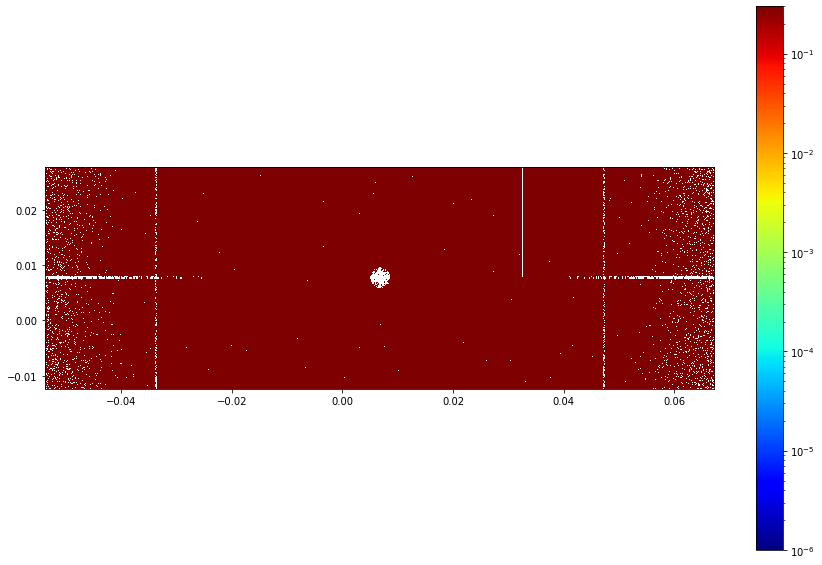

In [5]:
pixel_sum = np.zeros(config['cols'] * config['rows'])
for idx in range(len(indices)):
    pixel_sum[indices[idx]] += values[idx]

pixel_sum = np.reshape(pixel_sum, (config['cols'], config['rows']))
plot_pix_sum(pixel_sum, config)

## Analysis


In [6]:
mini_config = {
    'frames': frames_to_do,
    'pixels': config['cols'] * config['rows'],
    'delays_per_level': config['delays_per_level'],
    'rows': config['rows'],
    'cols': config['cols'],  
}

G2, IP, IF = libpx.multitau(sparse_data, mini_config)

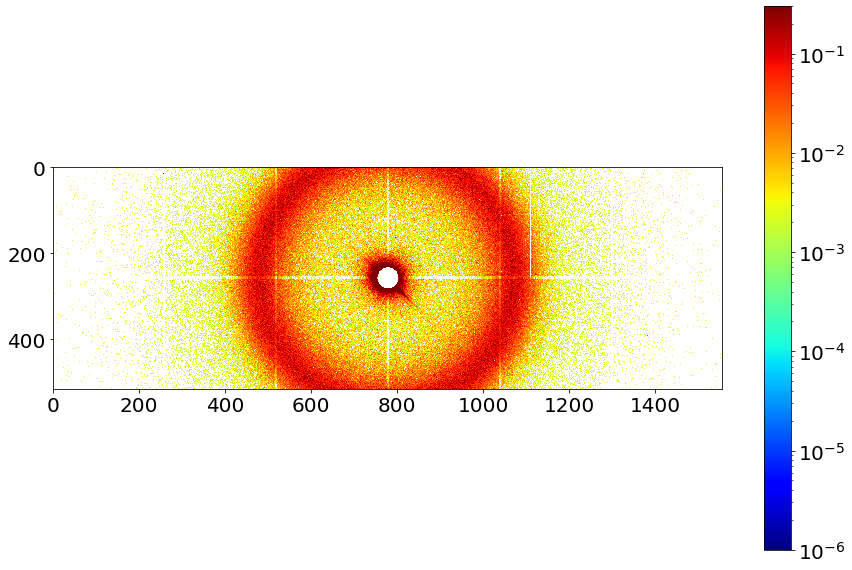

In [7]:
# In order to plot G2.
G2_plot = G2[0].reshape(config['cols'], config['rows'])
plot_as_image(G2_plot)

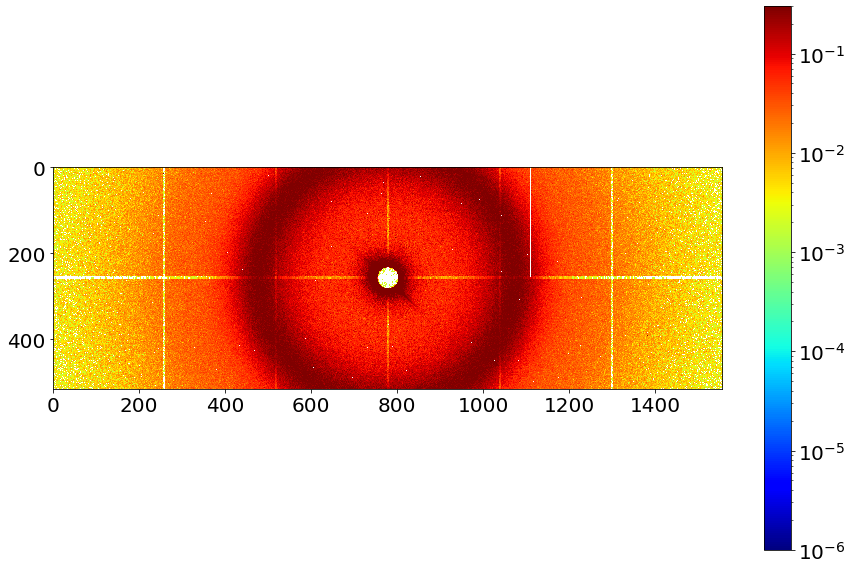

In [8]:
IP_plot = IP[0].reshape(config['cols'], config['rows'])
plot_as_image(IP_plot)

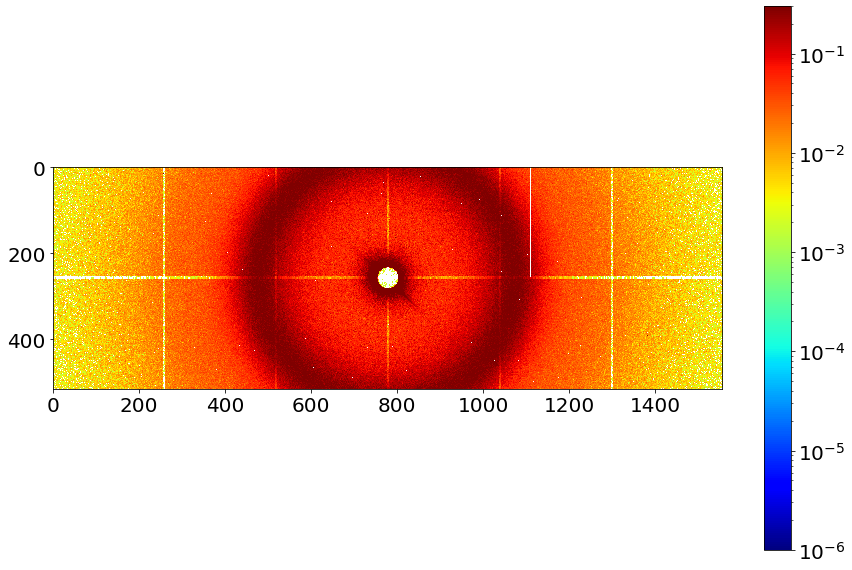

In [9]:
IF_plot = IF[0].reshape(config['cols'], config['rows'])
plot_as_image(IF_plot)

### g2 stderror

In [10]:
def compute_g2(G2, IP, IF, config):

    taus, pixels = G2.shape

    total_static_partitions = np.max(config['sqmap'])
    total_dynamic_partitions = np.max(config['dqmap'])

    # Final results
    g2 = np.zeros((taus, total_dynamic_partitions))
    g2_error = np.zeros((taus, total_dynamic_partitions))

    g2Sums = np.zeros((taus, total_static_partitions))
    ipSums = np.zeros((taus, total_static_partitions))
    ifSums = np.zeros((taus, total_static_partitions))

    dqmap = config['dqmap']
    sqmap = config['sqmap']


    IP_IF = IP * IF
    normalizedG2 = G2 /  (np.where( IP_IF != 0, IP_IF, 10000))

    # sum pixels for each static partitions
    for i in range(total_static_partitions):
        idx = (sqmap == i+1)
        g2Sums[:, i] = np.mean(G2[:, idx.flatten()], axis=1)
        ipSums[:, i] = np.mean(IP[:, idx.flatten()], axis=1)
        ifSums[:, i] = np.mean(IF[:, idx.flatten()], axis=1)

    ip_if_sums = ipSums * ifSums

    # Compute G2 error. 
    for i in range(total_dynamic_partitions):
        idx = (dqmap == i + 1)
        idx = idx.flatten()
        g2_error[:, i] = np.std(normalizedG2[:, idx], axis=1) / np.sqrt(pixels)

    for i in range(total_dynamic_partitions):
        low, high = np.amin(sqmap[dqmap == i+1]), np.max(sqmap[dqmap == i+1])
        tmp_g2_sum = g2Sums[:, low-1:high-1]
        g2[:, i] = np.mean(tmp_g2_sum / ip_if_sums[:, low-1:high-1], axis=1)
    
    return g2, g2_error

In [11]:
g2, g2_error = compute_g2(G2, IP, IF, config)

In [12]:
g2_q0 = g2[:, 5]

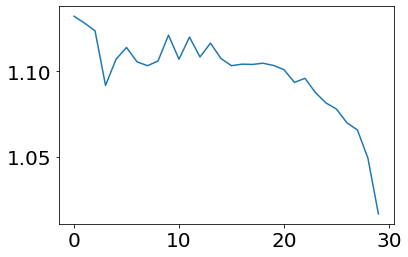

In [13]:
plt.plot(g2_q0)

## Verification

Verify the results with the C++ version directly

In [14]:
config2 = config_from_8idhdf5(RESULT_FILE)

In [15]:
ret = load_results(RESULT_FILE, '/exchange', ['pixelSum', 'G2', 'IP', 'IF'])

pixel_sum_computed = ret['pixelSum']
G2_computed = ret['G2']
IP_computed = ret['IP']
IF_computed = ret['IF']

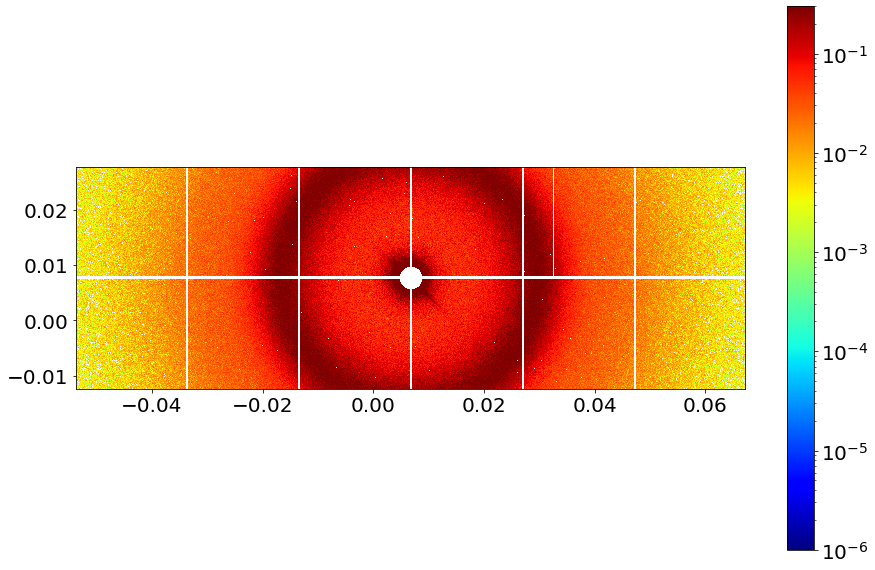

In [16]:
plot_pix_sum(pixel_sum_computed, config2)

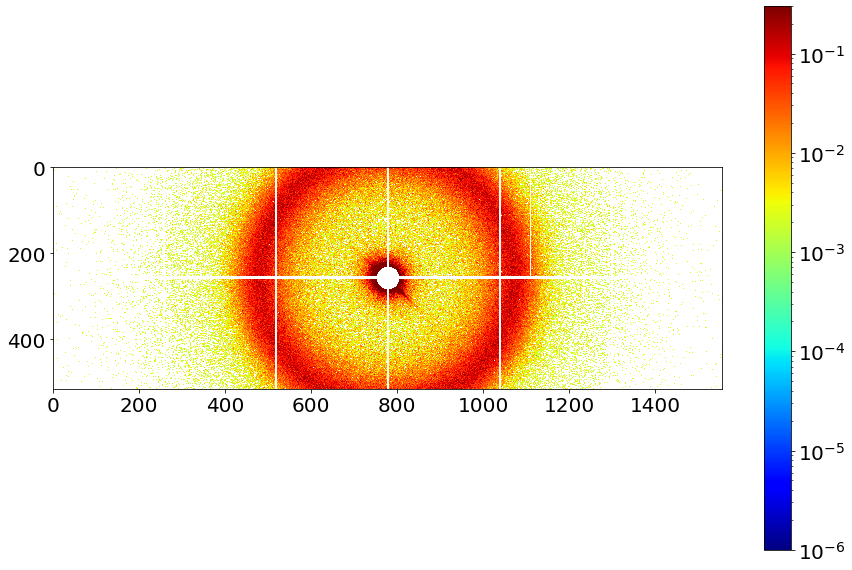

In [17]:
plot_as_image(G2_computed[0].reshape(config2['cols'], config2['rows']))

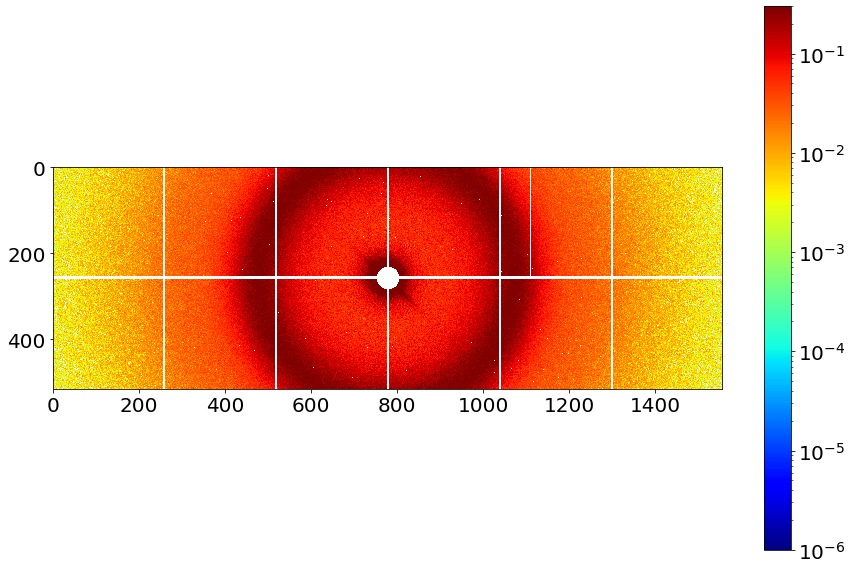

In [18]:
plot_as_image(IP_computed[0].reshape(config2['cols'], config2['rows']))

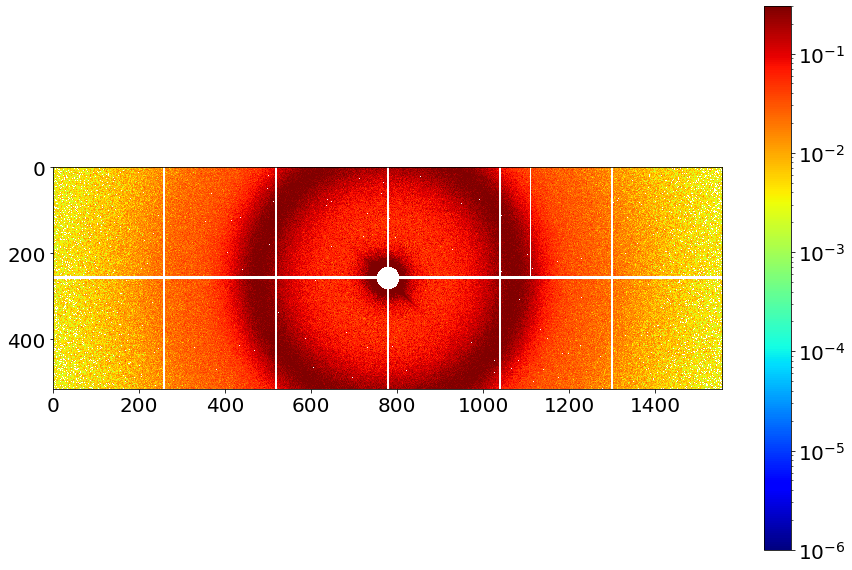

In [19]:
plot_as_image(IF_computed[0].reshape(config2['cols'], config2['rows']))